# imageAI simple object detection

In [1]:
from detection_v2 import ObjectDetection
import os

execution_path = os.getcwd()


detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath( os.path.join(execution_path , "resnet50_coco_best_v2.0.1.h5"))
detector.loadModel()
in_file = os.path.join(execution_path , "1.jpg")
out_file = os.path.join(execution_path , "image1new.jpg")
detections , objects_path= detector.detectObjectsFromImage(input_image=in_file, 
                                             output_image_path=out_file,
                                            extract_detected_objects=True)


for eachObject in detections:
    print(eachObject["name"] + " : " + eachObject["percentage_probability"] )
    print('bounding box position is :', eachObject["position"])
    print("--------------------------------")

E:\program\Anaconda3\envs\tensorflow_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


car : 87.62890100479126
bounding box position is : [1286 1398 1490 1475]
--------------------------------
car : 61.64518594741821
bounding box position is : [1573 1417 1696 1489]
--------------------------------
car : 74.99783039093018
bounding box position is : [1036 1422 1202 1579]
--------------------------------
car : 71.3244080543518
bounding box position is : [3155 1496 3262 1677]
--------------------------------
car : 81.80704116821289
bounding box position is : [1716 1416 2073 1550]
--------------------------------
car : 82.31039047241211
bounding box position is : [2876 1481 3192 1653]
--------------------------------
car : 92.87342429161072
bounding box position is : [ 909 1493 1147 1685]
--------------------------------
car : 95.69162130355835
bounding box position is : [1853 1518 2513 1721]
--------------------------------


# try to get the pose of car

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import data, exposure
import skimage
from sklearn.decomposition import PCA

E:\program\Anaconda3\envs\tensorflow_gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


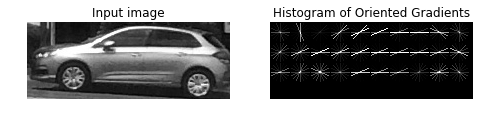

[4 3 3 4 4 3 4 4 4 4]


3.7

In [87]:
image = skimage.io.imread('image1new.jpg-objects/car-1.jpg')[:,:,0]
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(20, 20),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

print(pose_estimate(image))
np.mean(pose_estimate(image))

In [7]:
def reject_outliers_mask(data, m=2):
    mask = abs(data - np.mean(data)) < m * np.std(data)
    return data[mask], mask

def take_from_matrix(ori, idx):
    res = []
    for i in range(ori.shape[1]):
        res.append(ori[idx[i],i])
    return np.asarray(res)

In [81]:
def pose_estimate(image):
    size = 16
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(size, size),
                    cells_per_block=(1, 1), visualise=True)
    hh = int(image.shape[0]/size)
    ww = int(image.shape[1]/size)
    hist = (np.argmax(fd.reshape(-1,8),axis=1))*(np.max(fd.reshape(-1,8),axis=1)>0.35)
    hist = hist.reshape(hh,ww)
    idx = np.argmax(np.max(fd.reshape(-1,8),axis=1).reshape(hh,ww), axis = 0)
    value = take_from_matrix(hist,idx)
    return reject_outliers(value,1)

In [ ]:
def pos_object(eachObjects, depth):
    for eachObject in eachObjects:
        bbx = eachObject["position"]
        dep = depth[bbx[1]:bbx[3], bbx[0]:bbx[2]]
        dep = np.mean(reject_outliers(dep,1))

# signature of object and find correspondant objects

In [8]:
def calcule_distance(bbox, depth):
    depth_part = depth[bbx[1]:bbx[3], bbx[0]:bbx[2]]
    depth_part, mask = reject_outliers_mask(depth_part)
    return np.mean(depth_part), mask

def reject_outliers_mask(data, m=2):
    mask = abs(data - np.mean(data)) < m * np.std(data)
    return data[mask], mask

def reject_outliers(data, m=2):
    mask = abs(data - np.mean(data)) < m * np.std(data)
    return data[mask]

def pca_components(depth, mask):
    h,w = depth.shape
    pts = []
    for i in range(h):
        for j in range(w):
            if mask[i,j]:
                pts.append([i,j,depth[i,j]])
    pts = np.asarray(pts)
    pca = decomposition.PCA(n_components=3)
    pca.fit(pts)
    return pca.components_
    

In [9]:
directionary_cars = []
# need image and depth_map
h,w,_ = image.shape
for eachObject in detections:
    # "name", "percentage_probability", "position"
    # w_min, h_min, w_max, h_max = eachObject["position"]
    dirt = eachObject
    bbx = eachObject["position"]
    dirt["distance"], mask = calcule_distance(bbx, depth_map)
    r = np.ma.mean(image[bbx[1]:bbx[3], bbx[0]:bbx[2],0], mask)/255
    g = np.ma.mean(image[bbx[1]:bbx[3], bbx[0]:bbx[2],1], mask)/255
    b = np.ma.mean(image[bbx[1]:bbx[3], bbx[0]:bbx[2],2], mask)/255
    dirt["rgb"] = np.array([r,g,b])
    dirt["pca"] = pca_components(depth[bbx[1]:bbx[3], bbx[0]:bbx[2]], mask)
    dirt["bbx_center"] = np.array([bbx[1]+bbx[3]/(2*h), bbx[0]+bbx[2]/(2*w)])
    dirt["pos"] = np.array
    directionary_cars.append(dirt)

NameError: name 'detections' is not defined

In [2]:
def add_object_to_map(directionary_cars_old, 
                  directionary_cars_new, thres=[1,10]):

    # the coordinates of cars are in the same Coordinate System
    new_cars = [] 
    # find new cars or old cars from the new frame
    for car_new in directionary_cars_new:
        new = True
        for car in directionary_cars_old:
            if car_new["name"] == car["name"]:
                # if cars close to each other
                dd = (car_new["pos"] - car["pos"])
                # the distance in the feature space
                dist = 0
                dist = dist + np.sum(np.abs(car_new["rgb"] - car["rgb"]))
                dist = dist + np.sum(np.abs(car_new["pca"] - car["pca"]))
            
                if dd < thres[0] and dist < thres[1]:
                # they are cars correspondant
                    new = False
        if new:
            new_cars.append(car_new)

    for car_new in new_cars:
        directionary_cars_old.append(car_new)
                
    return directionary_cars_old

In [13]:
def some_function(directionary_cars_old, 
                  directionary_cars_new, thres=[1,10]):
    A = []
    B = []
    new_cars = []
    
    # find new cars or old cars from the new frame
    for car_new in directionary_cars_new:
        new = True
        for car in directionary_cars_old:
            if car_new["name"] = car["name"]:
                # if cars close to each other
                dd = (car_new["pos"] - car["pos"])
                # the distance in the feature space
                dist = 0
                dist = dist + np.sum(np.abs(car_new["rgb"] - car["rgb"]))
                dist = dist + np.sum(np.abs(car_new["pca"] - car["pca"]))
            
                if dd < thres[0] and dist < thres[1]:
                # they are cars correspondant
                    A.append(car_new["pos"])
                    B.append(car["pos"])
                    new = False
        if new:
            new_cars.append(car_new)
            
            
    leng = len(directionary_cars)
    for car_new in new_cars:
        car_new["pos"] = np.dot(M,car_new["pos"].T)
        for i in leng:
            car = directionary_cars[i]
            if np.norm(car_new["pos"]-car["pos"]) > 0.3:
                directionary_cars.append(car_new)
        
    return directionary_cars, M
        